In [3]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:127: RuntimeWarning: overflow encountered in add
  a = a + a
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:129: RuntimeWarning: invalid value encountered in subtract
  temp1 = temp - a
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:138: RuntimeWarning: invalid value encountered in subtract
  itemp = int_conv(temp-a)
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:162: RuntimeWarning: overflow encountered in add
  a = a + a
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:164: RuntimeWarning: invalid value encountered in subtract
  temp1 = temp - a
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:171: RuntimeWarning: invalid value encountered in subtract
  if any(temp-a != zero):


In [ ]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print gt.shape
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print 'generate density...'
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print 'done.'
    return density

In [4]:
#set the root to the Shanghai dataset you download
root = '/home/leeyh/Downloads/Shanghai/'

In [5]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [6]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [ ]:
for img_path in img_paths:
    print img_path
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

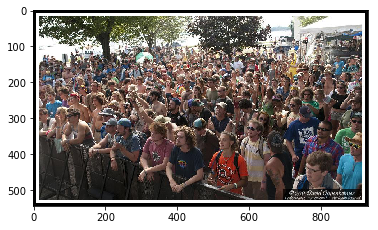

In [7]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

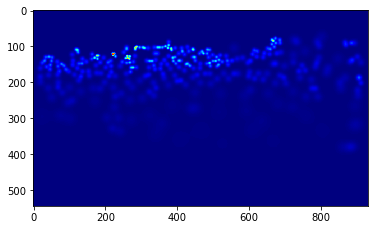

In [8]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
np.sum(groundtruth)# don't mind this slight variation

In [82]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [83]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [ ]:
for img_path in img_paths:
    print img_path
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

In [28]:
img,target = load_data(img_paths[3],False)

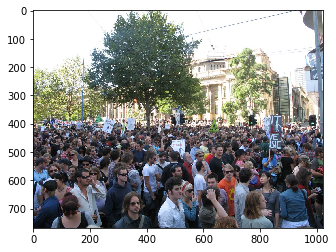

In [29]:
plt.imshow(img)

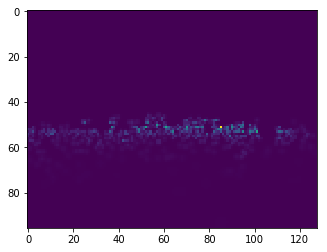

In [30]:
plt.imshow(target)

In [31]:
np.sum(target)

470.76907

In [13]:
model = CSRNet()

In [14]:
model = model.cuda()

In [35]:
checkpoint = torch.load('checkpoint.pth.tar')

In [36]:
model.load_state_dict(checkpoint['state_dict'])

In [37]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

In [32]:
img = transform(img).cuda()

In [33]:
output = model(img.unsqueeze(0))

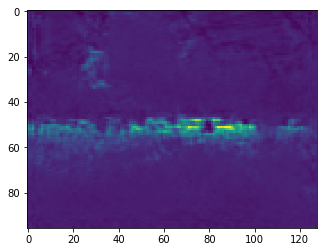

In [34]:
plt.imshow(output.detach().data[0][0])

In [79]:
output.sum()


 675.9519
[torch.cuda.FloatTensor of size () (GPU 0)]

In [80]:
output.detach().data[0][0]


 0.1434  0.1234  0.0495  ...   0.1739  0.2276  0.1423
 0.0921  0.0983  0.0990  ...   0.1779  0.2332  0.1596
 0.0746  0.0726  0.0798  ...   0.1717  0.1719  0.1201
          ...             ⋱             ...          
 0.0805  0.0718  0.0590  ...   0.1437  0.0687  0.0346
 0.1555  0.0931  0.0775  ...   0.0189 -0.0038 -0.0135
 0.1503  0.1057  0.0052  ...   0.1198  0.1014  0.1204
[torch.cuda.FloatTensor of size (70,128) (GPU 0)]

In [69]:
steps         = [-1,1,100,150]
scales        = [.01,100,.1,.1]
lr = 1e-6
epoch = 1
for i in range(len(steps)):
        
        scale = scales[i] if i < len(scales) else 1
        
        
        if epoch >= steps[i]:
            lr = lr * scale
            print lr
            if epoch == steps[i]:
                break
        else:
            break

1e-08
1e-06
